In [51]:
# ===========================
# This notebook tests and proves that we can do the Multiple Linear Regression (MLR) between DPCO2 and
# its drivers (SST, MLD, INTPP) correctly
# ===========================
# https://datatofish.com/multiple-linear-regression-python/
# ===========================

import netCDF4
import os
import cartopy.crs as ccrs
import numpy as np
import scipy.interpolate.ndgriddata as ndgriddata
import pickle
import sys
from scipy import stats
import mfilter

data_dir = '/data/mmenary/fgco2'
var_names = ['dpco2', 'tos', 'mlotst', 'intpp']
mlr_vars = var_names[1:]
year0s = [1850, 2100, 2350, 2600, 2850, 3100, 3350, 3600]


In [52]:
test_data = {}

tt0 = 0
tt1 = 12 * 30

for ivar, var_name in enumerate(var_names):
    filepath = os.path.join(data_dir, '{:s}_temp.nc'.format(var_name))
    loaded = netCDF4.Dataset(filepath)
    
    nav_lat = loaded.variables['nav_lat'][:-1, 1:-1]
    nav_lon = loaded.variables['nav_lon'][:-1, 1:-1]        
    test_data[var_name] = loaded.variables[var_name][tt0:tt1, :-1, 1:-1]

(360, 3)
(360,)
Intercept: 
 4.4872066e-09
Coefficients: 
 [-0.94901067  0.03963193 -0.1332852 ]


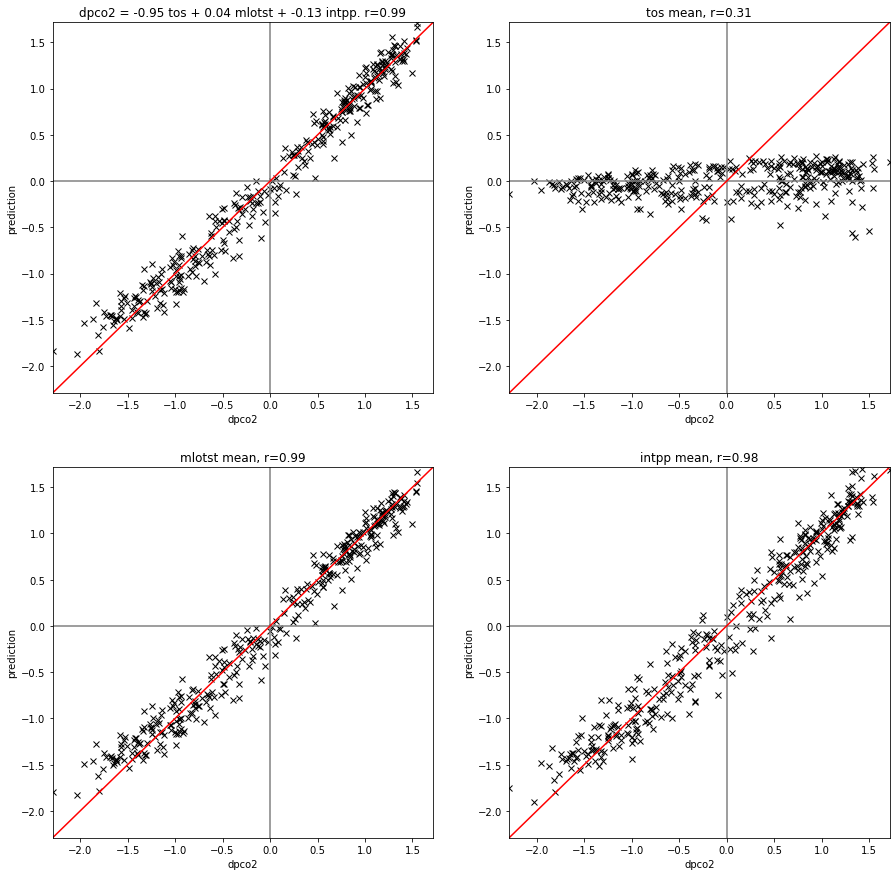

In [128]:
from sklearn import linear_model
import statsmodels.api as sm

jj = 150
ii = 150

tos = test_data['tos'][:, jj, ii]
mlotst = test_data['mlotst'][:, jj, ii]
intpp = test_data['intpp'][:, jj, ii]
dpco2 = test_data['dpco2'][:, jj, ii]

do_scaling = True
if do_scaling:
    tos -= tos.mean()
    mlotst -= mlotst.mean()
    intpp -= intpp.mean()
    dpco2 -= dpco2.mean()
    tos /= tos.std()
    mlotst /= mlotst.std()
    intpp /= intpp.std()
    dpco2 /= dpco2.std()

X = np.transpose(np.array((tos, mlotst, intpp)))
Y = dpco2

print(X.shape)
print(Y.shape)

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

xlim = [np.min(test_data['dpco2'][:, jj, ii]), np.max(test_data['dpco2'][:, jj, ii])]
nt = len(tos)

plt.figure(figsize=(15, 15))
for iplot in range(4):
    plt.subplot(2, 2, iplot + 1)
    if iplot == 0:
        Y2 = regr.predict(X)
        corr = np.corrcoef(Y2, Y)[0][1]
        plt.title('dpco2 = {:.2f} tos + {:.2f} mlotst + {:.2f} intpp. r={:.2f}'.format(regr.coef_[0], regr.coef_[1], regr.coef_[2], corr))
    elif iplot == 1:
        X2 = np.transpose(np.array((np.repeat(tos.mean(), nt), mlotst, intpp)))
        Y2 = regr.predict(X2)
        corr = np.corrcoef(Y2, Y)[0][1]
        plt.title('tos mean, r={:.2f}'.format(corr))
    elif iplot == 2:
        X2 = np.transpose(np.array((tos, np.repeat(mlotst.mean(), nt), intpp)))
        Y2 = regr.predict(X2)
        corr = np.corrcoef(Y2, Y)[0][1]
        prediction = regr.predict(X2)
        plt.title('mlotst mean, r={:.2f}'.format(corr))
    elif iplot == 3:
        X2 = np.transpose(np.array((tos, mlotst, np.repeat(intpp.mean(), nt))))
        Y2 = regr.predict(X2)
        corr = np.corrcoef(Y2, Y)[0][1]
        prediction = regr.predict(X2)
        plt.title('intpp mean, r={:.2f}'.format(corr))
        
    plt.plot(Y, Y2, 'x', color='k')
    plt.xlim(xlim)
    plt.ylim(xlim)
    plt.axhline(0, color='grey')
    plt.axvline(0, color='grey')
    plt.plot(xlim, xlim, color='red')
    plt.xlabel('dpco2')
    plt.ylabel('prediction')


1.0


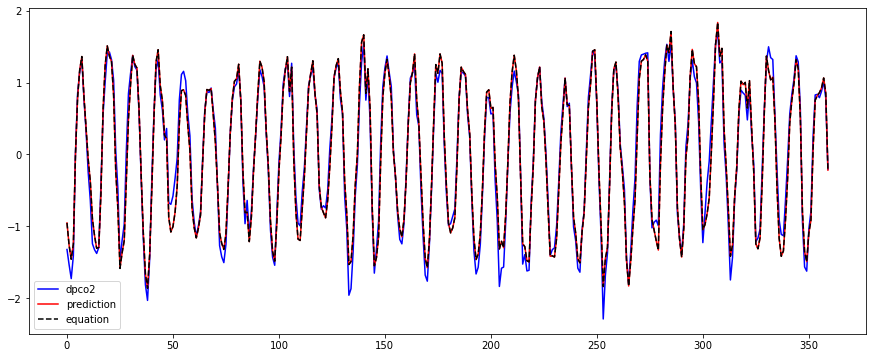

In [129]:
Y2 = regr.predict(X)
Y2b = tos * regr.coef_[0] + mlotst * regr.coef_[1] + intpp * regr.coef_[2] + regr.intercept_

plt.figure(figsize=(15, 6))

plt.plot(Y, label='dpco2', color='blue')
plt.plot(Y2, label='prediction', color='red')
plt.plot(Y2b, label='equation', linestyle='--', color='k')

plt.legend()

print((Y2 / Y2b).mean())

83 91 332 364
63 62 5795 5291
252 256 248 252


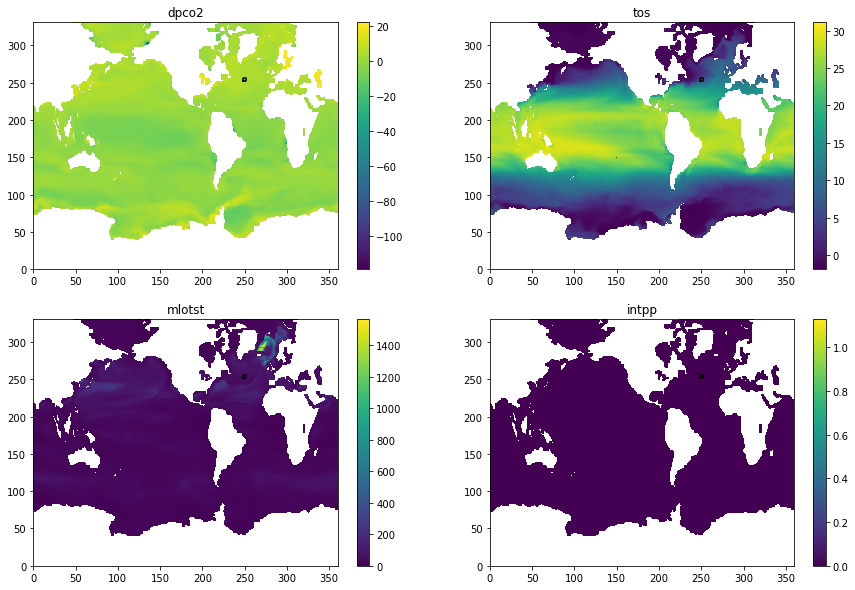

In [147]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
%matplotlib inline

plt.figure(figsize=(15, 10))
for iplot, var_name in enumerate(test_data.keys()):
    plt.subplot(2, 2, iplot+1)
    plt.pcolormesh(test_data[var_name][0, :, :])
    plt.colorbar()
    plt.title(var_name)

In [198]:
block_len = 30.
print(np.ceil(362 / block_len) * np.ceil(332 / block_len))

print(np.sqrt(block_len * block_len / (29 * 29) * 1.1))

156.0
1.0849746705208465
